In [3]:
import numpy as np
import pandas as pd
import scipy as sp
%matplotlib widget
import matplotlib.pyplot as plt
import seaborn as sns
import copy as cp
import itertools

Se necesita de la dependencia pyarrow. (pip install pyarrow)

# Train Data

In [4]:
data_train = pd.read_parquet("Data/train_data.parquet",engine="pyarrow")
data_train['date'] =  pd.to_datetime(data_train['date'])


Exploramos data

In [5]:
print("Número de datos:",data_train.size)
print("Stock elements:" ,data_train.sku.unique().size)
data_train.sample(10)

Número de datos: 338942511
Stock elements: 660916


,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
27717004,194367,2021-03-04,0,85.00,MEX,classic,fulfillment,paid_shipping,0.000000
29215673,549042,2021-03-19,1,229.68,MEX,premium,fulfillment,paid_shipping,1440.000000
36813660,641007,2021-03-31,0,377.00,ARG,classic,fulfillment,paid_shipping,1440.000000
33272293,426206,2021-02-18,0,169.00,MEX,premium,drop_off,paid_shipping,836.163667
37006486,456695,2021-02-23,3,3199.00,ARG,classic,fulfillment,paid_shipping,1440.000000
10352086,204991,2021-02-14,0,249.99,REA,premium,fulfillment,free_shipping,1440.000000
15754394,114947,2021-02-27,0,32.70,REA,premium,drop_off,paid_shipping,1440.000000
12866095,5600,2021-03-19,0,99.00,REA,premium,fulfillment,free_shipping,1440.000000
3406782,206107,2021-02-24,0,34.99,REA,classic,fulfillment,paid_shipping,1440.000000
1429985,576493,2021-02-02,0,42.99,REA,classic,cross_docking,paid_shipping,1440.000000


## Attributes 	Description
**date** : ranges from 1-2-21 to 31-3-21  
**sold_quantity** : 	number of units of the corresponding SKU that were sold on that particular date.  
**current_price** 	currency in which the price is expressed.  
**currency** 	point in time correct listing price.  
**listing_type** 	type of listing the SKU had for that particular date. Possible values are classic or premium and they relate to the exposure the items receive and the fee charged to the seller as a sales comission.  
**shipping_logistic_type** 	type of shipping method the SKU offered, for that particular date. Possible values are fulfillment, cross_docking and drop_off.  
**shipping_payment** 	whether the shipping for the offered SKU at that particular date was free or paid, from the buyer's perspective.  
**minutes_active** 	number of minutes the SKU was available for purchase on that particular date.  

## One `sku` analysis

In [13]:
sku_choices = np.random.choice(len(data_train.sku.unique()),1) #Choose sku at random
filt_sku = data_train[data_train.sku == sku_choices[0] ]
filt_sku.head()

,sku,date,sold_quantity,current_price,currency,listing_type,shipping_logistic_type,shipping_payment,minutes_active
20373673,125729,2021-02-01,0,404.0,MEX,classic,cross_docking,free_shipping,0.0
20373674,125729,2021-02-02,0,404.0,MEX,classic,cross_docking,free_shipping,0.0
20373675,125729,2021-02-03,0,404.0,MEX,classic,cross_docking,free_shipping,0.0
20373676,125729,2021-02-04,0,404.0,MEX,classic,cross_docking,free_shipping,0.0
20373677,125729,2021-02-05,0,404.0,MEX,classic,cross_docking,free_shipping,0.0


In [11]:
def pdf_n_days(dist_prob,n):
    """Returns the pdf after n iterations given the distribution probability of one iteration
    This is assuming that every iteration is independent of the previous one. So in this case the pdf is the convolution.
    Paraments:
    dist_prob (np.array): distribuion probability of one iteration
    n (integer): number of iterations
    
    Returns:
    probability(np.array): pdf after n iterations"""
    prob = cp.copy(dist_prob)
    for i in range(n):
        prob = np.convolve(prob,dist_prob)
    return prob

Text(0.5, 0, 'sells')

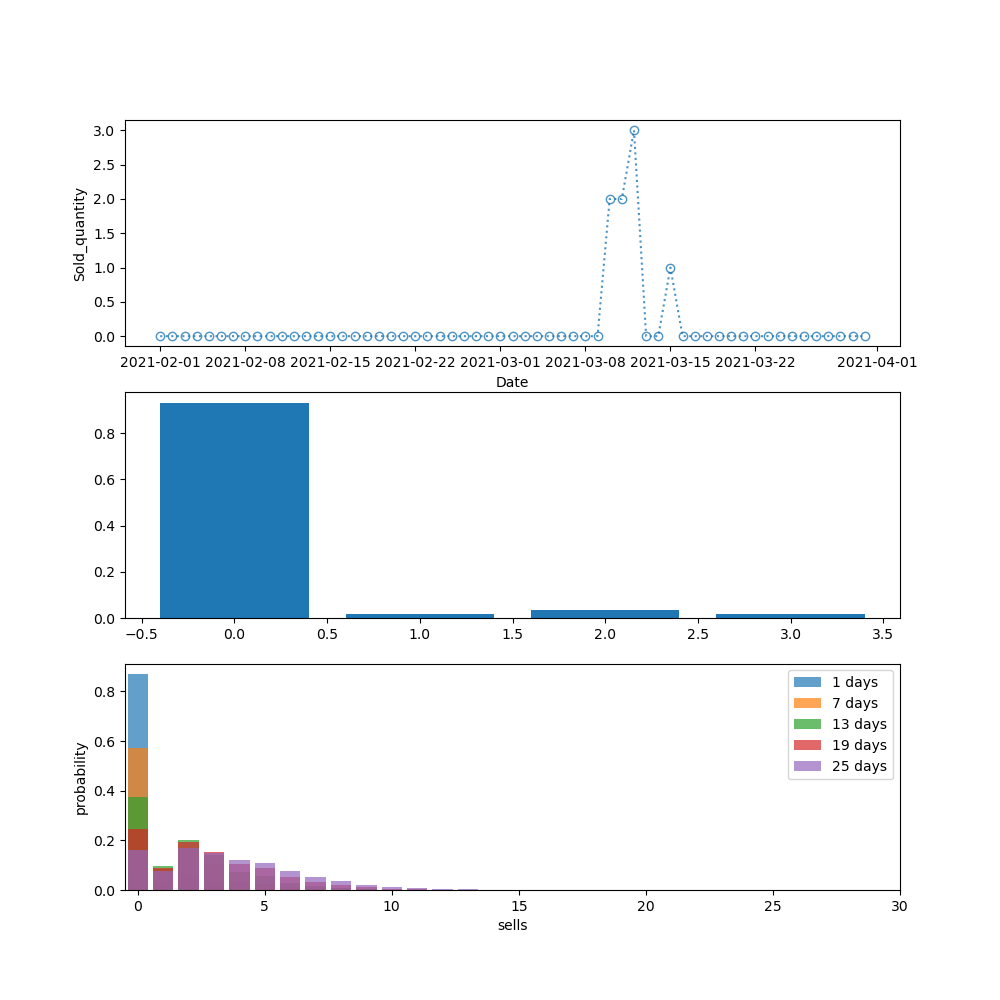

In [14]:
## Ploteamos un sold_quantity aleatorio

fig, ax = plt.subplots(3,1,figsize = (10,10))
ax[0].plot_date(filt_sku.date,filt_sku.sold_quantity,
             **dict(marker="o",linestyle=":",alpha=.8,mfc="none"))
ax[0].set_ylabel("Sold_quantity")
ax[0].set_xlabel("Date")

# Sacamos histograma de ventas y normalizamos, de esta se manera se obtienen probabilidades de vender N productos en un dado día.
hist,bins = np.histogram(filt_sku.sold_quantity,bins = np.arange(0,5,1))
prob = hist/hist.sum()
ax[1].bar(bins[:-1],prob)

#Convolucionando obtenemos la distribución de probabilidades para días siguientes
for n in np.arange(1,30,6):
    prob_n_days = pdf_n_days(prob,n)
    sells = np.arange(prob_n_days.size)
    ax[2].bar(sells,prob_n_days,alpha=.7,label = f"{n} days")
ax[2].set_ylabel("probability")
ax[2].legend()
ax[2].set_xlim(-0.5,30)
ax[2].set_xlabel("sells")


In [9]:
# -- what is the range of days for this sku?
T_sku464801 = filt_sku.date.max() - filt_sku.date.min()
print(f"Period is {T_sku464801.days} days")

# -- what is the total amount of sales for this sku?
tot_sold_sku464801 = filt_sku["sold_quantity"].sum()

print(f"This sku as a total of {tot_sold_sku464801} sales")

Period is 58 days
This sku as a total of 15 sales


## Analysis by `sku`

In [19]:
# -- Do we have the same amount of data by days for every sku?
#    Let's check the sku vs T[days] distribution

# tt = train_raw_DF.groupby(by=["sku","date"])
maxt = data_train.loc[:,["sku","date"]].groupby(by=["sku"]).max()
mint = data_train.loc[:,["sku","date"]].groupby(by=["sku"]).min()
T = maxt - mint

# -- convert T to int.
T.date = T.date.dt.days


In [21]:
_fs = 16
bin_edges = [0,5,10,15,20,25,30,35,40,45,50,55,56,57,58,59,60,70]
plt.figure()
plt.hist(x=T.date,bins=bin_edges,
         histtype="step",
         **dict(lw=2,alpha=.8))
plt.xlabel("T [days]",fontsize=_fs)
plt.ylabel("Count sku",fontsize=_fs)
plt.yscale("log")
plt.ylim((1e3,1e6))
plt.grid()
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Simple correlation analysis

There exists a correlation dependence on the number of elements sold?  
We calculate the correlations by `sku`. Since there are roughly 660000 sku, a correlation matrix would be of size 660000^2 elements, not practical. What to do?

In [36]:
sku_choices = np.random.choice(len(data_train.sku.unique()),2) #Choose sku at random

In [37]:
x = data_train[data_train.sku == sku_choices[0]]
y = data_train[data_train.sku == sku_choices[1]]

In [38]:
corr = np.correlate(x.sold_quantity,y.sold_quantity,mode = "full") # Correlate, this mode is not a simple correlation but a convolution. 

In [39]:
fig,ax = plt.subplots(1,2,figsize = (10,5))
days = np.arange(-corr.size//2,corr.size//2)
ax[0].plot(days,corr)
ax[0].set_ylabel("correlation")
ax[1].scatter(x.current_price,y.current_price)
ax[1].set_xlabel("x current price")
ax[1].set_ylabel("y current price")

<ipython-input-39-ef7c643c30a6>:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig,ax = plt.subplots(1,2,figsize = (10,5))


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'y current price')